In [224]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.optimize import root_scalar

## global variables


In [ ]:

global dt
global psi
global c
global v
global n
global k
global radius
global rho_o
global control_signal
global control_hold
global control_rate
global theta_dot_save
global gamma_save
global alpha_v
global dl
global ds 
global av
global bd_save
global pij_vec_3d
global pij_save
global vis_zone_vec2
global utj_vec
global gamma_ij_glob
gamma_ij_glob = []
utj_vec = []
vis_zone_vec_2 = []
pij_save = []
pij_vec_3d = []
theta_dot_save = []
gamma_save = []
bd_save = []
control_time_delay = 0.1

control_hold = 0
dt = 0.15
control_rate = int(control_time_delay/dt)
control_signal = []


'\n\ndl = 12\nds = 3\nav = np.pi/2\nc = 2\npsi = np.pi*(7/4)\ncj = 2 #cv\nkj = 0.0009 #kv\nv = 0.1\nn = 4\nk = 0.0005 # kb\nradius = 1.2\n# d_0 = 2*np.sin((2*np.pi/n)/2)*radius\nd_0 = 0.3\nlambda_v = np.exp((2*v)/(k*radius*np.pi))\n#rho_o = 10\nrho_o = ((c-1)*radius)/((lambda_v*c) - 1)\nprint(f"rho_o equals {rho_o}")\nprint(f"d_0 equals {d_0}")\ncontrol_signal = []\n\n'

## Constraint Checker


solution found, rho_e = 16.566572200596408
geo_constraint 1 is met!
geo_constraint 2 met, 0.6131866596349919 > 0.37060036494403453
constraint 1 met! the k ratio is 1.7999999999999998, right hand side is 2.0
constraint 2 met!, right hand side is -4.244131815783875
minimum f equals -0.7238347131313104


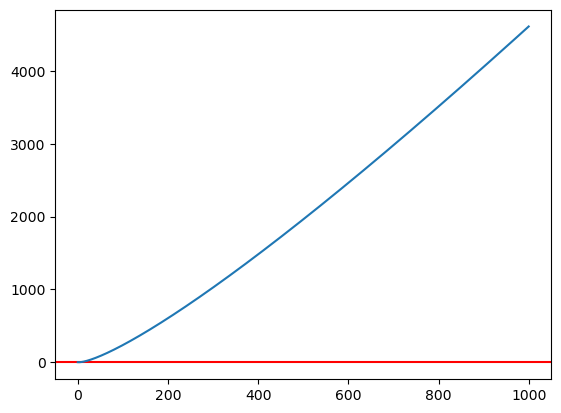

In [226]:
#simulation params from the paper
# # 3 agents params for crazyflies. for rho_e = 1.6 set rho_0 to 0.5
# rho_o = 0.5
# v = 0.3
# av = np.pi/4
# ds = 0.5
# dl = 1
# psi = np.pi * (7/4)
# d_0 = 1.285
# c = 2
# cj = 2
# # k = 0.075
# # kj = 0.15
# k = 0.05
# kj = 0.09
# n = 3

#simulation params from the paper
# # 3 agents params for crazyflies. for rho_e = 1.6 set rho_0 to 0.5
rho_o = 5
v = 1
av = np.pi/4
ds = 3
dl = 12
psi = np.pi * (7/4)
d_0 = 10
c = 2
cj = 2
k = 0.05
kj = 0.09
n = 4

####

#rho_e solver using root finding methods
def g_function2(rho_e,c,rho_o):
    g1 = np.log((((c-1)*rho_e) + rho_o)/(c*rho_o))
    if isinstance(rho_e, np.ndarray):
        for i in range(len(rho_e)):
            if rho_e[i] <0.000000001:
                g1[i] = 0
    else:
        if rho_e <0.000000001:
                g1 = 0
    return g1


def f(rho_e):
    return (v/rho_e) - k * g_function2(rho_e, c, rho_o) * (np.pi/2)

rho_guess = 1.0
rho_min = 0.1
rho_max = 200

solution = root_scalar(f, bracket=[rho_min, rho_max], method = 'brentq')
rho_e = solution.root
if solution.converged:
    root = solution.root
    print(f'solution found, rho_e = {root}')
else:
    print('no solution')

# Geometric constraint checker
def geo_constraint1(n, do, rho_e, av, dl):
    # Ensure arcsin argument is within [-1, 1]
    arcsin_input = dl / (2 * rho_e)
    arcsin_input2 = do / (2 * rho_e)
    if np.abs(arcsin_input) > 1 or np.abs(arcsin_input2) > 1:
        print(f"geo_constraint 1 is not met due to invalid arcsin input! 1:{arcsin_input} 2:{arcsin_input2}")
        return
    
    angle = min(av, np.arcsin(arcsin_input))
    if (n - 1) * np.arcsin(do / (2 * rho_e)) + angle < np.pi:
        print("geo_constraint 1 is met!")
    else:
        print("geo_constraint 1 is not met!")

def geo_constraint2(do, rho_e, av, dl):
    # Ensure arcsin argument is within [-1, 1]
    arcsin_input = dl / (2 * rho_e)
    arcsin_input2 = do / (2 * rho_e)
    if np.abs(arcsin_input) > 1 or np.abs(arcsin_input2) > 1:
        print(f"geo_constraint 2 is not met due to invalid arcsin input! 1:{arcsin_input} 2:{arcsin_input2}")
        return
    
    angle = min(av, np.arcsin(arcsin_input))
    if 2 * np.arcsin(do / (2 * rho_e)) > angle:
        print(f"geo_constraint 2 met, {2 * np.arcsin(do / (2 * rho_e))} > {angle}")
    else:
        print(f"geo_constraint 2 not met, {2 * np.arcsin(do / (2 * rho_e))} !> {angle}")

# Test functions with your parameters
geo_constraint1(n, d_0, rho_e, av, dl)
geo_constraint2(d_0, rho_e, av, dl)

# constraint checker

def constraint1(k,kj,c,cj):
    if kj/k <= 2 * (cj/c) * ((c-1)/(cj-1)):
        print(f"constraint 1 met! the k ratio is {kj/k}, right hand side is {2 * (cj/c) * ((c-1)/(cj-1))}")
        return True
    else:
        print(f"constraint1 not met! the k ratio is {kj/k}, right hand side is {2 * (cj/c) * ((c-1)/(cj-1))}")
        return False

# constraint 2: all f values must be greater than (-2 * v) / (3 * np.pi * k)
def constraint2(g_function, c, rho_o, v, k):
    global coord 
    rho = np.arange(0,1000,0.1)
    f = rho * g_function(rho,c,rho_o)
    if all(f > (-2 * v) / (3 * np.pi * k)):
        print(f'constraint 2 met!, right hand side is {(-2 * v) / (3 * np.pi * k)}')
        print(f"minimum f equals {min(f)}")
    else:
        print(f'constraint 2 not met, right hand side is {(-2 * v) / (3 * np.pi * k)}')
        print(f"minimum f equals {min(f)}")
    
    plt.figure()
    plt.axhline(y = (-2 * v) / (3 * np.pi * k), color = 'r')
    plt.plot(rho, f)
    plt.show()
    coord = f

constraint1(k,kj,c,cj)
constraint2(g_function2,c, rho_o, v, k)

In [227]:
# #simulation params from the paper
# # 3 agents params for crazyflies. for rho_e = 1.6 set rho_0 to 0.5
# v = 0.3
# av = np.pi/4
# ds = 0.5
# dl = 1
# psi = np.pi * 2
# d_0 = 1.285
# c = 2
# cj = 2
# # k = 0.075
# k = 0.075
# kj = 0.15
# # k = 0.05
# # kj = 0.09
# rho_o = 0.04
# n = 1

# #simulation params from the paper
# # 3 agents params for crazyflies. for rho_e = 1.6 set rho_0 to 0.5
# # v = 0.1
# # av = np.pi/4
# # ds = 0.2
# # dl = 12
# # psi = np.pi * (7/4)
# # d_0 = 1.5
# # c = 2
# # cj = 2
# # k = 0.05
# # kj = 0.09
# # # k = 0.05
# # # kj = 0.09
# # rho_o = 0.1
# # n = 2

Dynamics :

$\dot{x}(t) = v\cos \theta (t)\\$
$\dot{y}(t) = v\sin \theta (t)\\$
$\dot{theta}(t) = u(t)\\$

Control Law for one vehicle : 

$$
    u(t)= 
\begin{cases}
    k \cdot g(\rho (t) ; c,\rho_0) \cdot \alpha_d(\gamma(t)) ,& \text{if } \rho(t) > 0\\
    0,              & \text{if } \rho(t) = 0
\end{cases} \\
$$
with
$$
g(\rho ; c,\rho_0) = ln\Big (\frac{(c-1)\cdot \rho + \rho_0}{c \cdot \rho_0}\Big )\\
$$

$$
\alpha_d(\gamma) = \begin{cases}
    \gamma ,& \text{if } 0 \leq \gamma \leq \psi\\
    \gamma - 2 \pi,              & \text{if } \psi < \gamma \leq 2 \pi
\end{cases} \\
$$

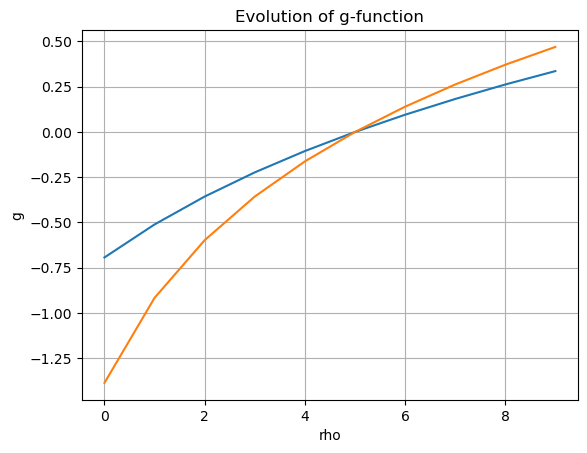

In [228]:
op1 = []
op2 = []
var_0 = 5
var_c1 = 2
var_c2 = 4
for var in range(10):
    op1.append(np.log((((var_c1-1)*var) + var_0)/(var_c1*var_0)))
    op2.append(np.log((((var_c2-1)*var) + var_0)/(var_c2*var_0)))
plt.plot(op1)
plt.plot(op2)

plt.title("Evolution of g-function")
plt.grid(True)
plt.xlabel('rho')
plt.ylabel('g')
plt.show()


In [229]:
def dist(a,b):
    d = np.array(a) - np.array(b)
    d = np.linalg.norm(d)
    return d

def get_angle(dx,dy):
    theta = np.arctan2(dy,dx)
    if(theta<0):
        theta = theta + 2*np.pi
    return theta

def get_angle_j(agent_vec,pij_vec):
    det = agent_vec[0] * pij_vec[1] - agent_vec[1] * pij_vec[0]
    dot = agent_vec[0] * pij_vec[0] + agent_vec[1] * pij_vec[1]
    theta = np.arctan2(det,dot)
    # tolerance = 1e-10
    # if abs(theta) < tolerance:
    #     theta = 0.0
    
    if theta < 0:
        theta += 2 * np.pi
    return theta

def g_function_j(pij, cv, do):
    g = np.log((((cv-1)*pij) + do)/(cv*do))
    if (pij<0.000000001):
        g = 0
    return g

# Controller for collision prevention

def Bd(gamma_ij):
    bd = []
    for i in range(len(gamma_ij)):
        gamma_ij_target = gamma_ij[i]
        if ((gamma_ij_target>=0) and (gamma_ij_target <= np.pi)):
            bd.append(gamma_ij_target)
        elif ((gamma_ij_target > np.pi)and (gamma_ij_target < 2*np.pi)):
            bd.append(gamma_ij_target - 2*np.pi)
        else :
            print("Error in gamma_ij value" + str(gamma_ij_target))
    bd_save.append(bd)
    return bd

def pij(x, n, agent_coord,agent_index):
    counter = 0
    pij = []
    pij_debug = []
    
    for i in range(n):
        if i == agent_index: 
            continue
        # print(f"Agent {i}: Comparing {agent_coord[0:2]} with {x[counter:counter+2]}")  # Debug print
        pij_magnitude = dist(agent_coord[0:2], x[3*i:3*i+2])  # Check distances
        # print(f"Distance for agent {i}: {pij_magnitude}")  # Debug the calculated distance
        
        pij_debug.append(pij_magnitude)
        pij.append(pij_magnitude)
        # Skip over x, y, theta
    
    pij_save.append(pij_debug)
    return pij


def gamma_ij(x,n,agent_coord,agent_index):
    
    gamma_ij_vec = []
    theta_agent = agent_coord[2]
    agent_vec = [np.cos(theta_agent),np.sin(theta_agent)]
    for i in range(n):
        if i == agent_index:
            continue
        pij_vector = x[3*i:3*i+2] - agent_coord[0:2]
        # pij_theta = get_angle(pij_vector[1],pij_vector[0])
        gamma_ij = get_angle_j(agent_vec,pij_vector)
        
        # print(f"pij theta = {pij_theta}")
        # print(f"agent coord = {theta_agent}")
        # gamma_ij = pij_theta - theta_agent
        gamma_ij_vec.append(gamma_ij)
    return gamma_ij_vec

def visibility_zone_detector(dl,ds,alpha_v,Bd_vec,pij):  # call in u_t_j
    visible = []
    #v_vector = [v*np.cos(theta), v*np.sin(theta)]
    for i in range(len(pij)):
        if pij[i] < ds:
            visible.append(True)
            continue
        elif ((pij[i] <= dl) and (abs(Bd_vec[i]) <= alpha_v)):
            visible.append(True)
        else:
            visible.append(False)
    return visible

def u_t_j(pij,b_d,cv,do,kv,visible): # return 0 when none within range_finder
    u_ij = []
    for i in range(len(visible)):
        if visible[i]:
            bij = b_d[i]
            gij = g_function_j(pij[i],cv,do)
            u_ij.append(kv*gij*bij)
    u = sum(u_ij)
    return u

                
    


In [230]:


def g_function(xb,xv,c,rho_o):
    rho_v = np.array(xb) - np.array(xv)
    rho = np.linalg.norm(rho_v)
    g = np.log((((c-1)*rho) + rho_o)/(c*rho_o))
    if (rho<0.000000001):
        g = 0
    return g

def alpha_d(gamma,psi):
    if ((gamma>=0)and (gamma <=psi)):
        return gamma
    elif ((gamma>psi)and (gamma <2*np.pi)):
        return gamma - 2*np.pi
    else :
        print("Error in gamma value" + str(gamma))
        return 0.0


def u_t(xv,xb,heading):
    gamma = get_angle(xb[0] - xv[0],xb[1] - xv[1]) - heading
    while (gamma>2*np.pi):
        gamma = gamma -2*np.pi
    while (gamma<0):
        gamma = gamma + 2*np.pi
    #print(np.rad2deg(gamma))
    alpha = alpha_d(gamma,psi)

    g = g_function(xb,xv,c,rho_o)
    # print(f"g is {g}")
    # print(f'alpha is {alpha}')
    u = k*g*alpha
    if dist(xv,xb) < 0.1:
        u = 0
    control_signal.append(u)
    return u


def gamma_angle(xv,xb,heading):
    gamma = get_angle(xb[0] - xv[0],xb[1] - xv[1]) - heading
    while (gamma>2*np.pi):
        gamma = gamma -2*np.pi
    while (gamma<0):
        gamma = gamma + 2*np.pi
    return gamma

def velocity(t,n):
    return np.ones(n)*v
def adjust_angle(x,n):
    for i in range (n):
        while (x[(3*i)+2]>2*np.pi):
            x[(3*i)+2] = x[(3*i)+2] -2*np.pi
        while (x[(3*i)+2]<0):
            x[(3*i)+2] = x[(3*i)+2] + 2*np.pi
    return x

def f_unicycle(t,x,n):
    xb = np.array([0 , 0])
    v_vec = velocity(t,n)
    visible = None
    pij_vec = None
    utj = None
    pij_vec_2 = []
    gamma_ij_vec = None
    theta_dot_vec = []
    gamma_vec = []
    vis_zone_vec = []
    utj_save = []
    gamma_ij_save = []
    Bd_vec = None
    for i in range(n):
        gamma_ij_vec = (gamma_ij(x,n,x[3*i:(3*i)+3],i))
        # gamma_ij_save.append(gamma_ij_vec)
        Bd_vec = Bd(gamma_ij_vec)
        pij_vec = pij(x,n,x[3*i:(3*i)+3],i)
        pij_vec_2.append(pij_vec)
        visible = visibility_zone_detector(dl,ds,av,Bd_vec,pij_vec)
        vis_zone_vec.append(visible)
        utj = u_t_j(pij_vec,Bd_vec,cj,d_0,kj,visible)
        utj_save.append(utj)
        theta_dot_vec.append(u_t(x[3*i:(3*i)+2],xb,x[(3*i)+2]) + utj)
        # gamma_vec.append(gamma_angle(x[3*i:(3*i)+2],xb,x[(3*i)+2]) + u_t_j(x[3*i:(3*i)+2],x[3*((i+1)%n):(3*((i+1)%n))+2],x[(3*i)+2]))
        gamma_vec.append(gamma_angle(x[3*i:(3*i)+2],xb,x[(3*i)+2]))
    # gamma_ij_glob.append(gamma_ij_save)
    utj_vec.append(utj_save)
    vis_zone_vec_2.append(vis_zone_vec)
    pij_vec_3d.append(pij_vec_2)
    rhs = []
    theta_dot_save.append(theta_dot_vec)
    gamma_save.append(gamma_vec)

    for i in range(n):
        v = v_vec[i]
        theta_dot = theta_dot_vec[i]
        theta = x[(3*i) + 2]
        rhs.append([(v*np.cos(theta)),(v*np.sin(theta)),(theta_dot)])
    #theta_dot_save
    # print(rhs)
    rhs = np.array(rhs)
    rhs = rhs.flatten()
    return rhs
    # return theta_dot_vec

def rk4_step(f,x,t,dt,n):
    k1 = f(t,x,n)
    k2 = f(t + (0.5*dt),x + (0.5*k1*dt),n)
    k3 = f(t + (0.5*dt),x + (0.5*k2*dt),n)
    k4 = f(t + dt,x + (k3*dt),n)

    return dt*((k1 + (2*k2) + (2*k3) + k4)/6)


def get_angle(dx,dy):
    theta = np.arctan2(dy,dx)
    if(theta<0):
        theta = theta + 2*np.pi
    return theta


# def get_theta_dot(T,dt,t,x,n):
#     theta_dot = []
#     thet_dot = []
#     for i in tqdm(range(int(T/dt))):
#         thet_dot = f_unicycle(t,x,n)
#         x = x + dx
#         x = adjust_angle(x,n)
#         t = t + dt
#         theta_dot.append(thet_dot)
#     theta_dot = np.array(theta_dot)
#     return theta_dot




In [231]:
# x0 = np.array([0,0,0,
#                5,0,np.pi/2,
#                5,5,np.pi,
#                0,5,3*np.pi/2])
offset = 20
# x0 = np.array([0/10-offset,0/10-offset,0,
#                5/10-offset,0/10-offset,np.pi/2,
#                5/10-offset,5/10-offset,np.pi,
#                0/10-offset,5/10-offset,3*np.pi/2])
# x0_4agent = np.array([0/1-offset,0/1-offset,0,
#                5/1-offset,0/1-offset,np.pi/2,
#                5/1-offset,5/1-offset,np.pi,
#                0/1-offset,5/1-offset,3*np.pi/2])
x0_5agent = np.array([0/1-offset,0/1-offset,0,
               5/1-offset,0/1-offset,0+np.pi/2,
               5/1-offset,5/1-offset,0+np.pi,
               0/1-offset,5/1-offset,0+(3/2)*np.pi,
               10,0,0])
x0_4agent = np.array([0/1-offset,0/1-offset,0,
               5/1-offset,0/1-offset,0,
               5/1-offset,5/1-offset,0,
               0/1-offset,5/1-offset,0])


x0_3agent = np.array([0/1-offset,0/1-offset,0,
               5/1-offset,0/1-offset,np.pi/2,
               5/1-offset,5/1-offset,np.pi,])

x0_2agent = np.array([-1.8,-1.2,0,
               -3,-1.2,0,])

x0_1agent = np.array([-2.333,-1.183,0])



# x0 = np.array([0,0,0,
#                5,0,0.2,
#                3,7,0.3,
#                -2,8,0.4])

# x0 = np.array([2,0,1.57])
# x0 = np.array([0,0,1.57])
# n = 4

#2 agents
"""
traj = [x0_2agent]
x = x0_2agent
"""

# 3 agents
"""
traj = [x0_3agent]
x = x0_3agent
"""

# 4 agents
#"""
traj = [x0_4agent]
x = x0_4agent
#"""

# 5 agents
"""
traj = [x0_2agent]
x = x0_2agent
"""

t = 0
T = 700
# global counter
# counter = 0

for i in tqdm(range(int(T/dt) )):
    dx = rk4_step(f_unicycle,x,t,dt,n)
    x = x + dx
    x = adjust_angle(x,n)
    t = t + dt
    traj.append(x)
    # counter += counter + 1 



  0%|          | 0/4666 [00:00<?, ?it/s]

100%|██████████| 4666/4666 [00:06<00:00, 723.07it/s]


Velocity :  1


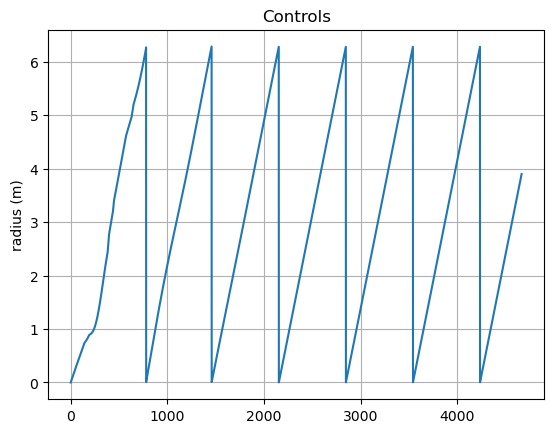

In [232]:
print("Velocity : ", v)
plt.plot(np.array(traj)[:,2])
plt.title("Controls")
plt.grid(True)
plt.ylabel("radius (m)")
plt.show()

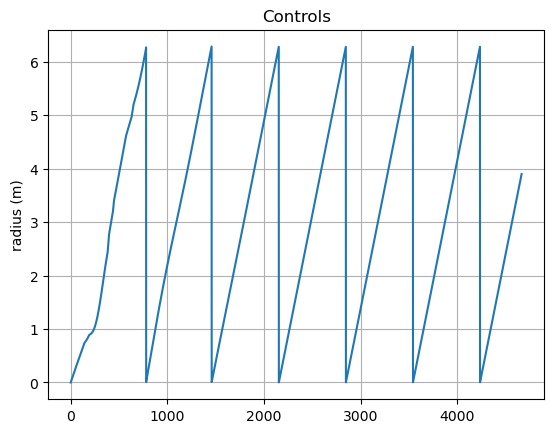

In [233]:
plt.plot(np.array(traj)[:,2])
plt.title("Controls")
plt.grid(True)
plt.ylabel("radius (m)")
plt.show()

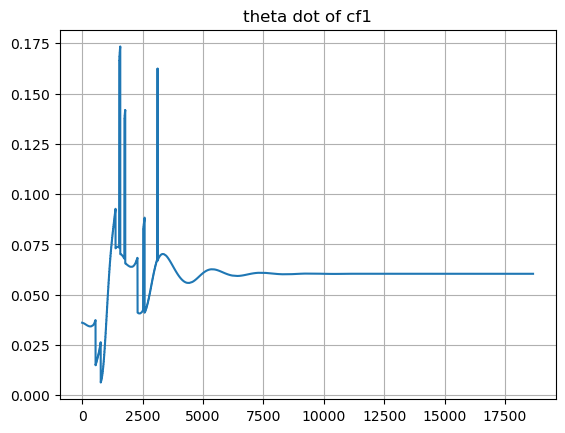

In [234]:
plt.plot(np.array(theta_dot_save)[:,0]) # on the left
plt.title("theta dot of cf1")
plt.grid(True)

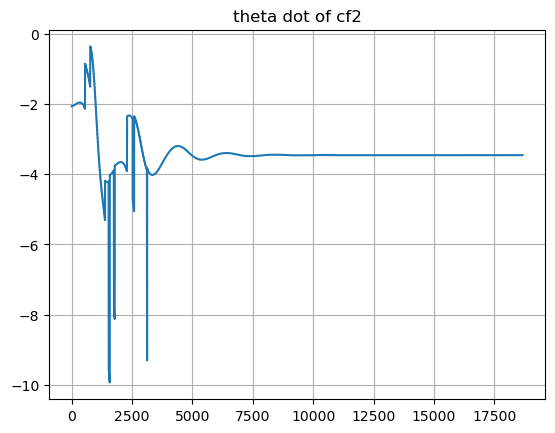

In [235]:
plt.plot(np.array(theta_dot_save)[:,0] * -180/np.pi) # on the right
plt.title("theta dot of cf2")
plt.grid(True)

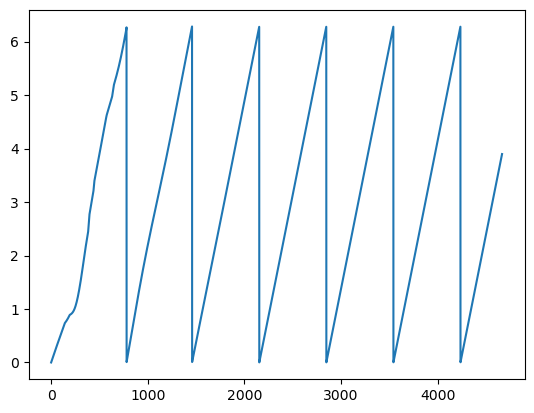

In [236]:
plt.plot(np.array(traj)[0:5000,2])

In [237]:
def distance(a,b):
    d = np.sqrt(((a[0]-b[0])**2)+((a[1]-b[1])**2))
    return d

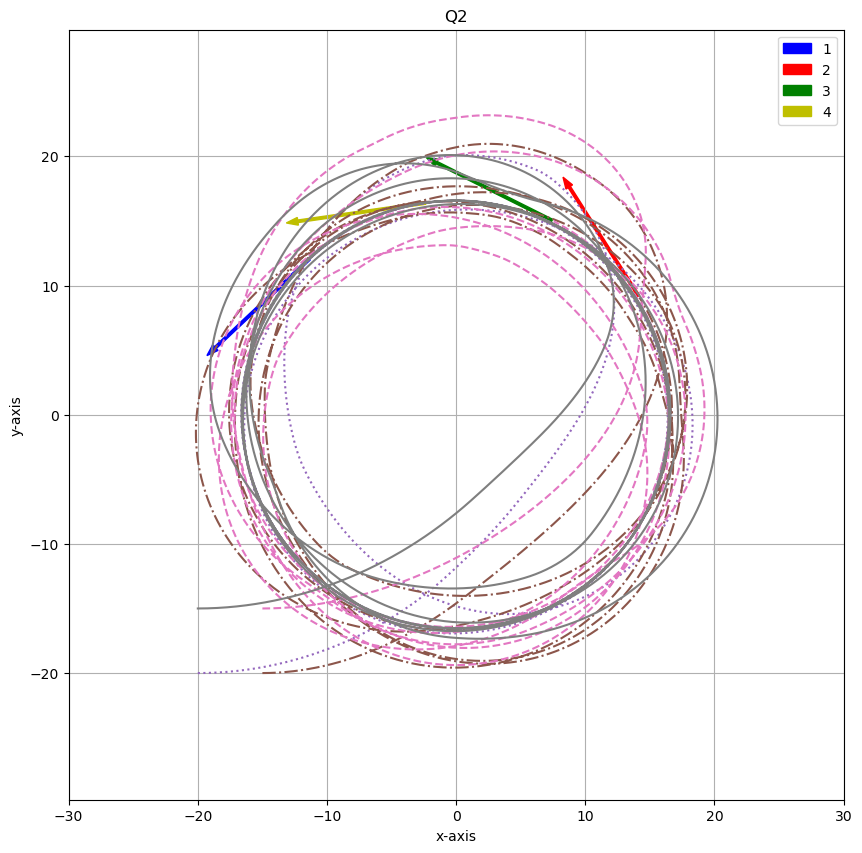

final coordinate [-11.36333641  12.05507442   3.8974621   14.1199012    9.19332117
   2.13693949   7.42550518  15.03961865   2.67738439  -2.35823029
  16.39402519   3.28410978]
actual do = 9.87703886632271


"\ndisplay_horizon = 5000\nplt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)\n\nplt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)\nplt.axis('equal')\nplt.title('Q2')\nplt.xlabel('x-axis')\nplt.ylabel('y-axis')\n\narrow_size = 0.5\nplt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.025,label = '1',color = 'b')\nplt.legend()\nplt.grid()\nplt.axis([-3.5,2.5,-2.5,2.5])\nplt.show()\n"

In [242]:
plt.figure(figsize=(10,10))

# plt.plot(np.array(traj)[:,0],np.array(traj)[:,1])
# plt.plot(np.array(traj)[:,2],np.array(traj)[:,3])
# plt.plot(np.array(traj)[:,4],np.array(traj)[:,5])
# plt.plot(np.array(traj)[:,6],np.array(traj)[:,7])
# plt.axis('equal')
# plt.show()

#5 agents 
'''
display_horizon = 5000
plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon,3],np.array(traj)[0:-display_horizon,4],'-.',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon:,6],np.array(traj)[0:-display_horizon,7],'--',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon,9],np.array(traj)[0:-display_horizon,10],alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon,12],np.array(traj)[0:-display_horizon,13],alpha = 0.4)


plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,3],np.array(traj)[-display_horizon:-1,4],'-.',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,6],np.array(traj)[-display_horizon:-1,7],'--',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,9],np.array(traj)[-display_horizon:-1,10],alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,12],np.array(traj)[-display_horizon:-1,13],alpha = 1)
plt.axis('equal')
plt.title('Q2')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

arrow_size = 10
plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.2,label = '1',color = 'b')
plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],arrow_size*np.cos(np.array(traj)[-1,5]),arrow_size*np.sin(np.array(traj)[-1,5]),width=.2,label = '2',color = 'r')
plt.arrow(np.array(traj)[-1,6],np.array(traj)[-1,7],arrow_size*np.cos(np.array(traj)[-1,8]),arrow_size*np.sin(np.array(traj)[-1,8]),width=.2,label = '3',color = 'g')
plt.arrow(np.array(traj)[-1,9],np.array(traj)[-1,10],arrow_size*np.cos(np.array(traj)[-1,11]),arrow_size*np.sin(np.array(traj)[-1,11]),width=.2,label = '4',color = 'y')
plt.arrow(np.array(traj)[-1,12],np.array(traj)[-1,13],arrow_size*np.cos(np.array(traj)[-1,14]),arrow_size*np.sin(np.array(traj)[-1,14]),width=.2,label = '4',color = 'k')
plt.legend()
plt.grid()
plt.axis([-30,30,-30,30])
plt.show()

print(f"final coordinate {traj[-1][:]}")
a_coord = traj[-1][0:2] #blue 
b_coord = traj[-1][3:5] #red
c_coord = traj[-1][6:8] #green
d_coord = traj[-1][9:11] #yellow
d = distance(c_coord,d_coord)
print(f"actual do = {d}")
'''

#4 agents 
#'''
display_horizon = 5000
plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon,3],np.array(traj)[0:-display_horizon,4],'-.',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon:,6],np.array(traj)[0:-display_horizon,7],'--',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon,9],np.array(traj)[0:-display_horizon,10],alpha = 0.4)

plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,3],np.array(traj)[-display_horizon:-1,4],'-.',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,6],np.array(traj)[-display_horizon:-1,7],'--',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,9],np.array(traj)[-display_horizon:-1,10],alpha = 1)
plt.axis('equal')
plt.title('Q2')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

arrow_size = 10
plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.2,label = '1',color = 'b')
plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],arrow_size*np.cos(np.array(traj)[-1,5]),arrow_size*np.sin(np.array(traj)[-1,5]),width=.2,label = '2',color = 'r')
plt.arrow(np.array(traj)[-1,6],np.array(traj)[-1,7],arrow_size*np.cos(np.array(traj)[-1,8]),arrow_size*np.sin(np.array(traj)[-1,8]),width=.2,label = '3',color = 'g')
plt.arrow(np.array(traj)[-1,9],np.array(traj)[-1,10],arrow_size*np.cos(np.array(traj)[-1,11]),arrow_size*np.sin(np.array(traj)[-1,11]),width=.2,label = '4',color = 'y')
plt.legend()
plt.grid()
plt.axis([-30,30,-30,30])
plt.show()

print(f"final coordinate {traj[-1][:]}")
a_coord = traj[-1][0:2] #blue 
b_coord = traj[-1][3:5] #red
c_coord = traj[-1][6:8] #green
d_coord = traj[-1][9:11] #yellow
d = distance(c_coord,d_coord)
print(f"actual do = {d}")
#'''

# 3 agents
"""
display_horizon = 5000
plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon,3],np.array(traj)[0:-display_horizon,4],'-.',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon:,6],np.array(traj)[0:-display_horizon,7],'--',alpha = 0.4)

plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,3],np.array(traj)[-display_horizon:-1,4],'-.',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,6],np.array(traj)[-display_horizon:-1,7],'--',alpha = 1)
plt.axis('equal')
plt.title('Q2')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

arrow_size = 6
plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.1,label = '1',color = 'b')
plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],arrow_size*np.cos(np.array(traj)[-1,5]),arrow_size*np.sin(np.array(traj)[-1,5]),width=.1,label = '2',color = 'r')
plt.arrow(np.array(traj)[-1,6],np.array(traj)[-1,7],arrow_size*np.cos(np.array(traj)[-1,8]),arrow_size*np.sin(np.array(traj)[-1,8]),width=.1,label = '3',color = 'g')
plt.legend()
plt.grid()
plt.axis([-50,50,-50,50])
plt.show()
"""

#2 agents
"""
display_horizon = 5000
plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)
plt.plot(np.array(traj)[0:-display_horizon,3],np.array(traj)[0:-display_horizon,4],'-.',alpha = 0.4)

plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
plt.plot(np.array(traj)[-display_horizon:-1,3],np.array(traj)[-display_horizon:-1,4],'-.',alpha = 1)
plt.axis('equal')
plt.title('Q2')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

arrow_size = 0.5
plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.025,label = '1',color = 'b')
plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],arrow_size*np.cos(np.array(traj)[-1,5]),arrow_size*np.sin(np.array(traj)[-1,5]),width=.025,label = '2',color = 'r')
plt.legend()
plt.grid()
plt.axis([-3.5,2.5,-2.5,2.5])
plt.show()
"""

#1 agents
"""
display_horizon = 5000
plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)

plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
plt.axis('equal')
plt.title('Q2')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

arrow_size = 0.5
plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.025,label = '1',color = 'b')
plt.legend()
plt.grid()
plt.axis([-3.5,2.5,-2.5,2.5])
plt.show()
"""


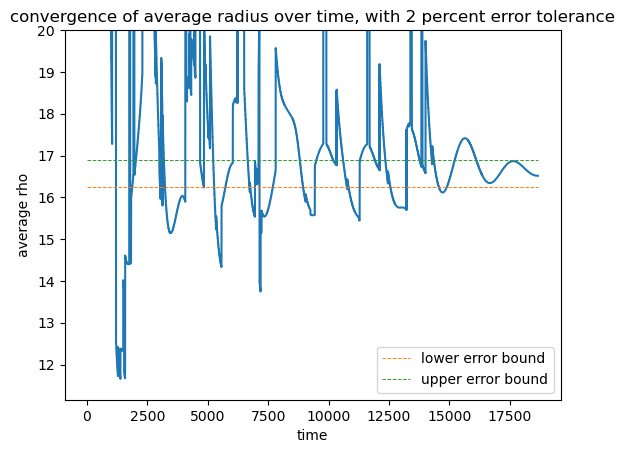

most recent average radius is [16.51562799]


In [244]:
#plots average rotational radius
tol = 0.02
bound = [rho_e + rho_e * tol, rho_e - rho_e * tol]

theta_dot_save = np.array(theta_dot_save)
rho = abs(v / theta_dot_save) 
avg_rho = np.empty([rho.shape[0], 1])
time = np.arange(0,T,dt) 

for i in range(rho.shape[0]):
    avg_rho[i] = np.average(rho[i,:])
plt.plot(avg_rho)
plt.plot([0, len(avg_rho)],[bound[1],bound[1]], linestyle = '--', linewidth = 0.7, label = 'lower error bound')
plt.plot([0, len(avg_rho)],[bound[0],bound[0]], linestyle = '--', linewidth = 0.7, label = 'upper error bound')
ax = plt.gca()
ax.set_ylim([min(avg_rho)-0.5, 20])

#Error_percent = abs(avg_rho-solution.root) / solution.root * 100 



plt.xlabel('time')
plt.ylabel('average rho')
ax.legend()
ax.set_title('convergence of average radius over time, with 2 percent error tolerance')
plt.show()
print(f"most recent average radius is {avg_rho[-1]}")






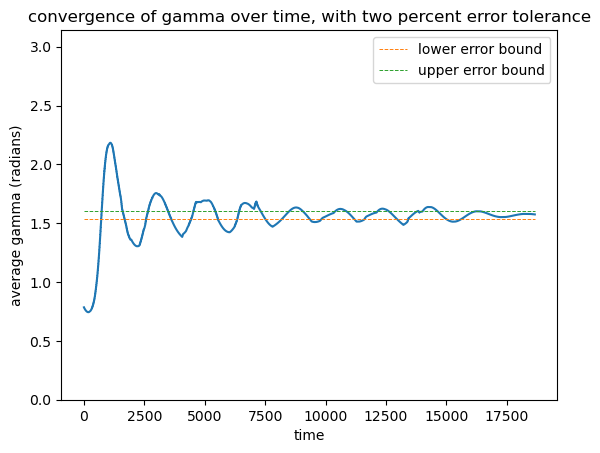

In [240]:
#plots average gamma vs time
bound_gamma = [np.pi/2 + np.pi/2 * tol, np.pi/2 - np.pi/2 * tol]
gamma_save = np.array(gamma_save)
avg_gamma = np.empty([gamma_save.shape[0],1])

for i in range(gamma_save.shape[0]):
    avg_gamma[i] = np.average(gamma_save[i,:])
plt.plot(avg_gamma)
plt.plot([0, len(avg_gamma)],[bound_gamma[1],bound_gamma[1]], linestyle = '--', linewidth = 0.7, label = 'lower error bound')
plt.plot([0, len(avg_gamma)],[bound_gamma[0],bound_gamma[0]], linestyle = '--', linewidth = 0.7, label = 'upper error bound')
plt.xlabel('time')
plt.ylabel('average gamma (radians)')
ax = plt.gca()
ax.set_ylim(0,np.pi)
ax.legend()
ax.set_title('convergence of gamma over time, with two percent error tolerance')
plt.show()



In [241]:
bound
print(f"last pij vec {pij_vec_3d[-1]}")
print(f"minimum pij vec {min(pij_vec_3d)}")
print(f"visible or not {vis_zone_vec_2[-1]}")
print(f"last utj vector {utj_vec[-1]}")
# print(gamma_ij_glob[-1])

last pij vec [[25.643420809474, 19.024407283189415, 9.995920671288431], [25.643420809474, 8.887864344367047, 17.982740495140426], [19.024407283189415, 8.887864344367047, 9.87703885838065], [9.995920671288431, 17.982740495140426, 9.87703885838065]]
minimum pij vec [[2.9763294703913847, 3.7944277396121846, 4.399496860584345], [2.9763294703913847, 4.2544808869682464, 7.277617855817044], [3.7944277396121846, 4.2544808869682464, 5.507109580127859], [4.399496860584345, 7.277617855817044, 5.507109580127859]]
visible or not [[False, False, False], [False, True, False], [False, False, True], [True, False, False]]
last utj vector [0, -0.0014766703214744285, -0.0001813005565503595, -5.626824589969725e-06]
